<a href="https://colab.research.google.com/github/vit050587/neural_networks/blob/master/KVA_INN_HW_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание:
#### Используя файл Web2.ipynb (он в полезных ссылках):

Возьмите набор примеров fashion-MNIST

1. Опишите - какой результат нейросети получен в зависимости от:<br>
    a. числа нейронов в слое (для 2-х слойной сети),<br>
    b. числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых параметров).<br>
    c. фиксируйте для тренировочного и тестового набора метрики accuracy.<br>

2. Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1. Фиксируйте для тренировочного и тестового набора метрики accuracy.

3. Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе?

4. Для одного варианта сети сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота, точность).

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools

import tensorflow as tf

import keras
from keras.datasets import fashion_mnist
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

from keras.optimizers import SGD
from keras.optimizers import Adagrad
from keras.optimizers import RMSprop
from keras.optimizers import Adam

keras.__version__

'2.12.0'

In [9]:
(X_train, y_train_labels), (X_test, y_test_labels) = fashion_mnist.load_data()

print(X_train.shape, X_test.shape)
print(y_train_labels.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,)


Label is 5


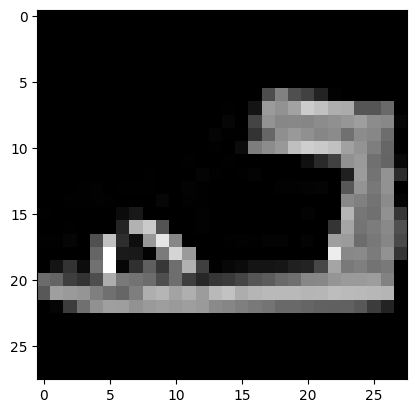

In [10]:
ind = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[ind], cmap='gray')
print(f'Label is {y_train_labels[ind]}')

In [11]:
# Нормировка
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train.min(), X_train.max()

(0.0, 1.0)

In [12]:
# Вытягивание признаков
X_train = X_train.reshape((-1, 28 * 28))
X_test = X_test.reshape((-1, 28 * 28))

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

## Задание 1 a

1. Опишите - какой результат нейросети получен в зависимости от:<br>
    a. числа нейронов в слое (для 2-х слойной сети),<br>

In [13]:
model_history = []
n_list = [int(i) for i in np.geomspace(5, 500, num=15, axis=0).tolist()]


for n_neurons in tqdm(n_list):

    # define the keras model
    model = Sequential()
    model.add(Dense(n_neurons, input_shape=(28 * 28,), activation='relu'))
    model.add(Dense(10, activation='sigmoid'))
    #model.summary()

    config = model.get_config()

    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

    # метод для перевода меток класса в OneHot представление
    y_train = to_categorical(y_train_labels)
    y_test = to_categorical(y_test_labels)

    y_train[:5]


    # передача обучающего датасета keras модели
    history = model.fit(X_train, y_train,
                        epochs=5,
                        batch_size=64,
                        verbose=0,
                        validation_data=(X_test, y_test)
                        # если передаём датасет для валидации,
                        # в отчёте отображаются метрики на валидационном датасете
                        )
    model_history.append([history, n_neurons])

100%|██████████| 15/15 [05:02<00:00, 20.19s/it]


In [14]:
model_history[0][0].history['accuracy'][-1]

0.7644333243370056

In [15]:
# создаём пустой датафрейм
df = pd.DataFrame(columns=['no. neurons', 'train accuracy', 'val_accuracy'])
i = 0
for i in range(len(model_history)):
    # добавляем кол-во нейронов, и последние метрики (по 5-й эпохе) каждой модели
    df.loc[i] = [model_history[i][1], model_history[i][0].history['accuracy'][-1],\
                 model_history[i][0].history['val_accuracy'][-1]]
    i += 1
df

,no. neurons,train accuracy,val_accuracy
0,5.0,0.764433,0.7659
1,6.0,0.786950,0.7786
2,9.0,0.821600,0.8129
3,13.0,0.822133,0.8145
4,18.0,0.832950,0.8246
5,25.0,0.832050,0.8201
6,35.0,0.830750,0.8261
7,49.0,0.835783,0.8222
8,69.0,0.836733,0.8287
9,96.0,0.836250,0.8252


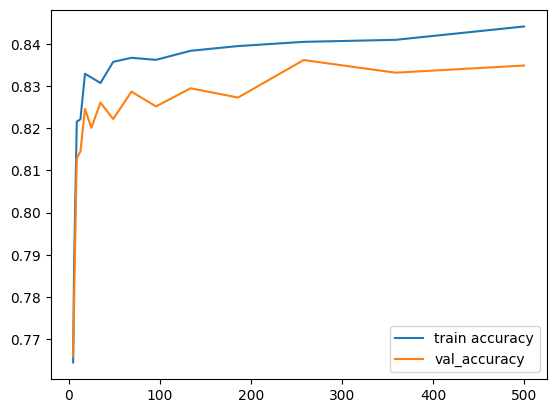

In [16]:
plt.plot(df['no. neurons'], df['train accuracy'], label='train accuracy')
plt.plot(df['no. neurons'], df['val_accuracy'], label='val_accuracy')
plt.legend();

**Вывод**: несмотря на то, что есть некоторые провалы (особенно на валидационной метрике), в целом, с ростом количества нейронов качество растёт.

## Задание 1b

1. Опишите - какой результат нейросети получен в зависимости от:<br>
    b. числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых параметров).<br>

**2-х слойная модель, входной слой = 28 нейронов**

In [17]:
# define the keras model
model = Sequential()
model.add(Dense(28, input_shape=(28 * 28,), activation='relu'))
model.add(Dense(10, activation='sigmoid'))
#model.summary()

config = model.get_config()

model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

# метод для перевода меток класса в OneHot представление
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

# передача обучающего датасета keras модели
history_2 = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    verbose=0,
                    validation_data=(X_test, y_test)
                    # если передаём датасет для валидации,
                    # в отчёте отображаются метрики на валидационном датасете
                    )

In [18]:
# создаём пустой датафрейм
df_ = pd.DataFrame(columns=['architecture', 'train accuracy', 'val_accuracy'])

# добавляем метрики в датафрейм
df_.loc[1] = ['2 layers, input=28', history_2.history['accuracy'][-1],\
                 history_2.history['val_accuracy'][-1]]

df_

,architecture,train accuracy,val_accuracy
1,"2 layers, input=28",0.8351,0.8237


**2-х слойная модель, входной слой = 28 * 28 нейронов**

In [19]:
# define the keras model
model = Sequential()
model.add(Dense(28 * 28, input_shape=(28 * 28,), activation='relu'))
model.add(Dense(10, activation='sigmoid'))
#model.summary()

config = model.get_config()

model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

# метод для перевода меток класса в OneHot представление
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

# передача обучающего датасета keras модели
history_2 = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    verbose=0,
                    validation_data=(X_test, y_test)
                    # если передаём датасет для валидации,
                    # в отчёте отображаются метрики на валидационном датасете
                    )

In [20]:
# добавляем метрики в датафрейм
df_.loc[2] = ['2 layers, input=28*28', history_2.history['accuracy'][-1],\
                 history_2.history['val_accuracy'][-1]]

df_

,architecture,train accuracy,val_accuracy
1,"2 layers, input=28",0.835100,0.8237
2,"2 layers, input=28*28",0.846433,0.8392


**3-х слойная модель, входной слой = 28 нейронов**

In [21]:
# define the keras model
model = Sequential()
model.add(Dense(28, input_shape=(28 * 28,), activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
#model.summary()

config = model.get_config()

model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

# метод для перевода меток класса в OneHot представление
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

# передача обучающего датасета keras модели
history_3 = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    verbose=0,
                    validation_data=(X_test, y_test)
                    # если передаём датасет для валидации,
                    # в отчёте отображаются метрики на валидационном датасете
                    )

In [22]:
# добавляем метрики в датафрейм
df_.loc[3] = ['3 layers, input=28', history_3.history['accuracy'][-1],\
                 history_3.history['val_accuracy'][-1]]

df_

,architecture,train accuracy,val_accuracy
1,"2 layers, input=28",0.835100,0.8237
2,"2 layers, input=28*28",0.846433,0.8392
3,"3 layers, input=28",0.832500,0.8193


**3-х слойная модель, входной слой = 28 * 28 нейронов**

In [23]:
# define the keras model
model = Sequential()
model.add(Dense(28*28, input_shape=(28 * 28,), activation='relu'))
model.add(Dense(392, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
#model.summary()

config = model.get_config()

model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

# метод для перевода меток класса в OneHot представление
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

# передача обучающего датасета keras модели
history_3 = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    verbose=0,
                    validation_data=(X_test, y_test)
                    # если передаём датасет для валидации,
                    # в отчёте отображаются метрики на валидационном датасете
                    )

In [24]:
# добавляем метрики в датафрейм
df_.loc[4] = ['3 layers, input=28*28', history_3.history['accuracy'][-1],\
                 history_3.history['val_accuracy'][-1]]

df_

,architecture,train accuracy,val_accuracy
1,"2 layers, input=28",0.835100,0.8237
2,"2 layers, input=28*28",0.846433,0.8392
3,"3 layers, input=28",0.832500,0.8193
4,"3 layers, input=28*28",0.854850,0.8312


**5-ти слойная модель, входной слой = 28 нейронов**

In [25]:
# define the keras model
model = Sequential()
model.add(Dense(28, input_shape=(28 * 28,), activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
#model.summary()

config = model.get_config()

model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

# метод для перевода меток класса в OneHot представление
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

# передача обучающего датасета keras модели
history_5 = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    verbose=0,
                    validation_data=(X_test, y_test)
                    # если передаём датасет для валидации,
                    # в отчёте отображаются метрики на валидационном датасете
                    )

In [26]:
# добавляем метрики в датафрейм
df_.loc[5] = ['5 layers, input=28', history_5.history['accuracy'][-1],\
                 history_5.history['val_accuracy'][-1]]

df_

,architecture,train accuracy,val_accuracy
1,"2 layers, input=28",0.835100,0.8237
2,"2 layers, input=28*28",0.846433,0.8392
3,"3 layers, input=28",0.832500,0.8193
4,"3 layers, input=28*28",0.854850,0.8312
5,"5 layers, input=28",0.833833,0.8257


**5-ти слойная модель, входной слой = 28 * 28 нейронов**

In [27]:
# define the keras model
model = Sequential()
model.add(Dense(28 * 28, input_shape=(28 * 28,), activation='relu'))
model.add(Dense(196, activation='relu'))
model.add(Dense(98, activation='relu'))
model.add(Dense(49, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
#model.summary()

config = model.get_config()

model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

# метод для перевода меток класса в OneHot представление
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

# передача обучающего датасета keras модели
history_5 = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    verbose=0,
                    validation_data=(X_test, y_test)
                    # если передаём датасет для валидации,
                    # в отчёте отображаются метрики на валидационном датасете
                    )

In [28]:
# добавляем метрики в датафрейм
df_.loc[6] = ['5 layers, input=28*28', history_5.history['accuracy'][-1],\
                 history_5.history['val_accuracy'][-1]]

df_

,architecture,train accuracy,val_accuracy
1,"2 layers, input=28",0.835100,0.8237
2,"2 layers, input=28*28",0.846433,0.8392
3,"3 layers, input=28",0.832500,0.8193
4,"3 layers, input=28*28",0.854850,0.8312
5,"5 layers, input=28",0.833833,0.8257
6,"5 layers, input=28*28",0.859600,0.8520


**10-ти слойная модель, входной слой = 28 нейронов**

In [29]:
# define the keras model
model = Sequential()
model.add(Dense(28, input_shape=(28 * 28,), activation='relu'))
model.add(Dense(26, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(22, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
#model.summary()

config = model.get_config()

model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

# метод для перевода меток класса в OneHot представление
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

# передача обучающего датасета keras модели
history_10 = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    verbose=0,
                    validation_data=(X_test, y_test)
                    # если передаём датасет для валидации,
                    # в отчёте отображаются метрики на валидационном датасете
                    )

In [30]:
# добавляем метрики в датафрейм
df_.loc[7] = ['10 layers, input=28', history_10.history['accuracy'][-1],\
                 history_10.history['val_accuracy'][-1]]

df_

,architecture,train accuracy,val_accuracy
1,"2 layers, input=28",0.835100,0.8237
2,"2 layers, input=28*28",0.846433,0.8392
3,"3 layers, input=28",0.832500,0.8193
4,"3 layers, input=28*28",0.854850,0.8312
5,"5 layers, input=28",0.833833,0.8257
6,"5 layers, input=28*28",0.859600,0.8520
7,"10 layers, input=28",0.792783,0.8114


**10-ти слойная модель, входной слой = 28 * 28 нейронов**

In [31]:
# define the keras model
model = Sequential()
model.add(Dense(28 * 28, input_shape=(28 * 28,), activation='relu'))
model.add(Dense(392, activation='relu'))
model.add(Dense(296, activation='relu'))
model.add(Dense(180, activation='relu'))
model.add(Dense(110, activation='relu'))
model.add(Dense(70, activation='relu'))
model.add(Dense(42, activation='relu'))
model.add(Dense(26, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
#model.summary()

config = model.get_config()

model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

# метод для перевода меток класса в OneHot представление
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

# передача обучающего датасета keras модели
history_10_ = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    verbose=0,
                    validation_data=(X_test, y_test)
                    # если передаём датасет для валидации,
                    # в отчёте отображаются метрики на валидационном датасете
                    )

In [32]:
# добавляем метрики в датафрейм
df_.loc[8] = ['10 layers, input=28*28', history_10_.history['accuracy'][-1],\
                 history_10_.history['val_accuracy'][-1]]

df_

,architecture,train accuracy,val_accuracy
1,"2 layers, input=28",0.835100,0.8237
2,"2 layers, input=28*28",0.846433,0.8392
3,"3 layers, input=28",0.832500,0.8193
4,"3 layers, input=28*28",0.854850,0.8312
5,"5 layers, input=28",0.833833,0.8257
6,"5 layers, input=28*28",0.859600,0.8520
7,"10 layers, input=28",0.792783,0.8114
8,"10 layers, input=28*28",0.859317,0.8103


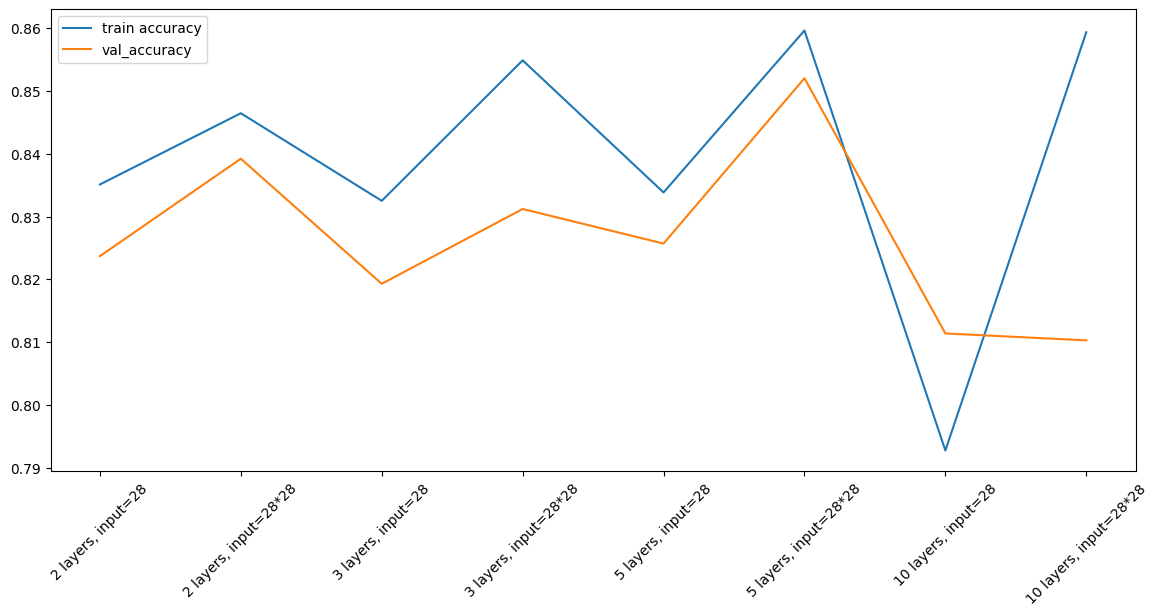

In [33]:
plt.figure(figsize=(14,6)) 
plt.plot(df_['architecture'], df_['train accuracy'], label='train accuracy')
plt.plot(df_['architecture'], df_['val_accuracy'], label='val_accuracy')
plt.xticks(rotation=45)
plt.legend();

**Вывод**: задание большего количества слоёв при одинаковом количестве эпох ухудшает скор.

## Задание 2

2. Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1. Фиксируйте для тренировочного и тестового набора метрики accuracy.

**Выберу для дальнейшей работы модель с лучшими метриками. Это 3-х слойная модель, входной слой = 28 * 28 нейронов.**

In [34]:
# параметры оптимизаторов
SGD(learning_rate=0.01, momentum=0.5)
Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07)
RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-07)
Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

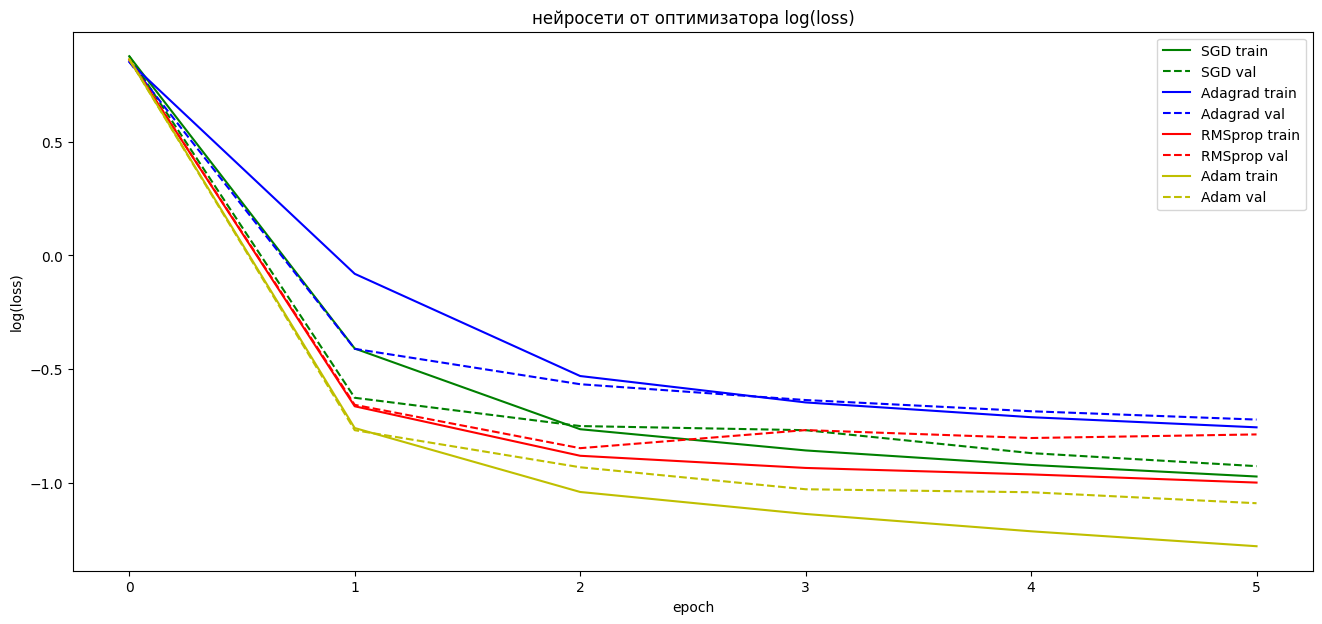

CPU times: user 10min 9s, sys: 22.2 s, total: 10min 31s
Wall time: 7min 43s


In [35]:
%%time
# фиксируем сид для создания весов
tf.random.set_seed(1)

# будем сохранять модели в словарь
models = {}

plt.figure(figsize=(16, 7))
colors = ['g', 'b', 'r', 'y']

num_epochs = 5
batch_size = 32

# вектор для вывода результатов
epoch = np.arange(num_epochs+1)

# будем изменять оптимизаторы
for i, i_optim in enumerate([keras.optimizers.SGD(),
                             keras.optimizers.Adagrad(),
                             keras.optimizers.RMSprop(),
                             keras.optimizers.Adam()]):
    
    model_i = Sequential([
        Dense(28 * 28, activation='relu', input_shape=(28 * 28,)),
        Dense(392, activation='relu'),
        Dense(10, activation='sigmoid'),
    ])
    
    # компилируем model_i с одним из оптимизаторов
    model_i.compile(
        optimizer=i_optim,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )
    
    # вычисляем ошибку для modeli без обучения
    h0_train = model_i.evaluate(X_train, y_train, verbose=0)
    h0_val = model_i.evaluate(X_test, y_test, verbose=0)

    # проводим обучение модели 
    h = model_i.fit(X_train, y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    verbose=0)

    # записываем обученную модель в словарь
    models[i_optim.get_config()['name']] = model_i

    # картинки
    plt.plot(epoch, np.log([h0_train[0]] + h.history['loss']),
             '-', c=colors[i],
             label=model_i.optimizer.get_config()['name'] + ' train')
    plt.plot(epoch, np.log([h0_val[0]] + h.history['val_loss']),
             '--', c=colors[i],
             label=model_i.optimizer.get_config()['name'] + ' val')

plt.legend()
plt.title('нейросети от оптимизатора log(loss)')
plt.xlabel('epoch')
plt.ylabel('log(loss)')
plt.show()

## Задание 3

3. Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе?

In [36]:
h.history

{'loss': [0.46761569380760193,
  0.35285064578056335,
  0.32027050852775574,
  0.29677435755729675,
  0.277882844209671],
 'accuracy': [0.8314833045005798,
  0.8700666427612305,
  0.8824166655540466,
  0.8890666961669922,
  0.8965166807174683],
 'val_loss': [0.46317607164382935,
  0.3934119641780853,
  0.35710108280181885,
  0.35243096947669983,
  0.3358089327812195],
 'val_accuracy': [0.8323000073432922,
  0.8551999926567078,
  0.8705000281333923,
  0.8737999796867371,
  0.8833000063896179]}

**Вывод**: у модели без оптимизатора скор был = 0.8403. С оптимизатором Адам = 0.8797.
Оптимизатор помог улучшить качество.

## Задание 4

4. Для одного варианта сети сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота, точность).

In [37]:
y_pred = model_i.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class

313/313 [==============================] - 1s 4ms/step


array([9, 2, 1, ..., 8, 1, 5])

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


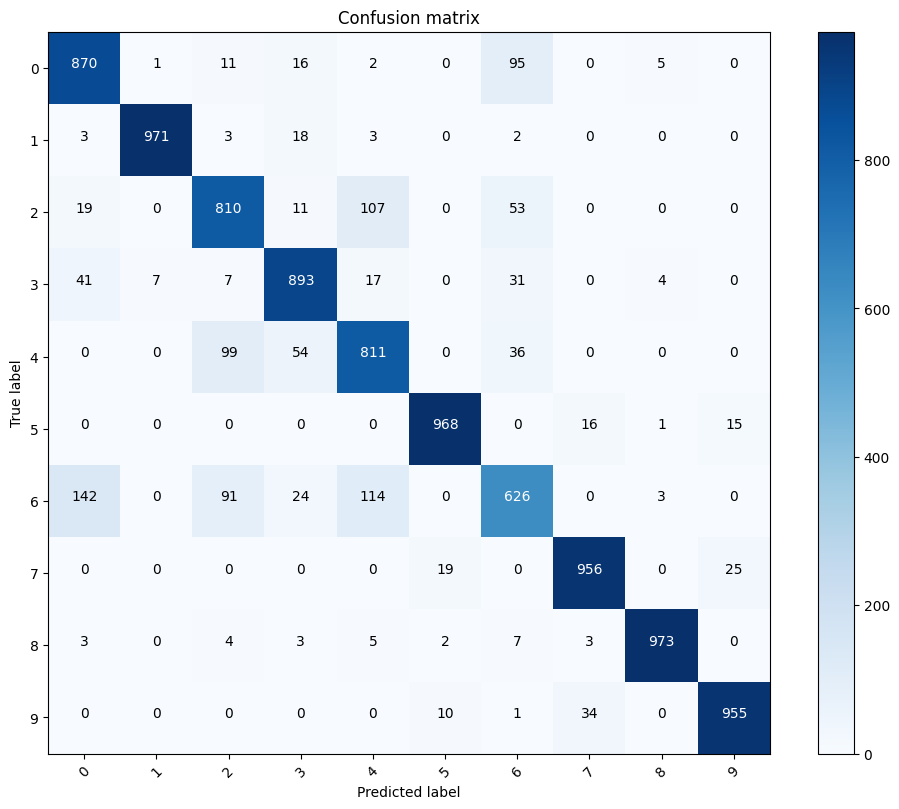

In [43]:
#font = {'size' : 15}
#plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_labels, y_pred_class)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
                      title='Confusion matrix', normalize=False)
plt.show()

**Оценим качество модели по каждому классу отдельно (полнота, точность).**

In [44]:
def get_precision_and_recall_from_confusion_matrix(label, cnf_matrix):
    str_sum = 0
    col_sum = 0
    for i in range(len(cnf_matrix)):
        str_sum += cnf_matrix[label][i]
        col_sum += cnf_matrix[i][label]
        
    return cnf_matrix[label][label] / str_sum, cnf_matrix[label][label] / col_sum

In [45]:
pr_rc_result = pd.DataFrame()
precisions = []
recalls = []
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for l in labels:
    p_r = get_precision_and_recall_from_confusion_matrix(l, cnf_matrix)
    precisions.append(p_r[0])
    recalls.append(p_r[1])
pr_rc_result['label'] = labels
pr_rc_result['precision'] = precisions
pr_rc_result['recall'] = recalls

pr_rc_result.sort_values(by='precision', ascending=False)

,label,precision,recall
8,8,0.973,0.986815
1,1,0.971,0.991828
5,5,0.968,0.968969
7,7,0.956,0.947473
9,9,0.955,0.959799
3,3,0.893,0.876349
0,0,0.870,0.807050
4,4,0.811,0.765817
2,2,0.810,0.790244
6,6,0.626,0.735605
